In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

<div class="jumbotron">
    <p class="display-1 h1">汇聚层</p>
    <hr class="my-4">
    <p>主讲：李岩</p>
    <p>管理学院</p>
    <p>liyan@cumtb.edu.cn</p>
</div>

## 感受野

- 当处理图像时，希望逐渐降低隐藏表示的空间分辨率、聚集信息
- 这样随着神经网络中层叠的上升，每个神经元对其敏感的感受野（输入）就越大

\begin{definition}\label{def:receptiveField}
感受野（receptive field）：在深度学习网络中，网络中隐藏单元的感受野是输入到该神经元的原始输入的区域。
\end{definition}


![](../img/6_convolutional_neural_networks/receptiveField.gif)

- 当特征图中的任何元素需要更大的感受野来检测更宽区域的输入特征时，可以构建更深的网络

\begin{example}\label{example:receptiveField}
考虑一个11维的输入，一个具有3个通道且大小为3的卷积核
\end{example}

一个隐藏层，H1中神经元的感受野是3
![](../img/6_convolutional_neural_networks/receptiveFieldOneLayer.png)

两个隐藏层，H2中神经元的感受野是5

![](../img/6_convolutional_neural_networks/receptiveFieldTwoLayers.png)

三个隐藏层，H3对应的卷积核的步幅为2，则H3中神经元的感受野是7

![](../img/6_convolutional_neural_networks/receptiveFieldThreeLayers.png)

四个隐藏层，H4中神经元的感受野是11，H3中卷积核的步幅为2

![](../img/6_convolutional_neural_networks/receptiveFieldFourLayersStride2.png)

### 感受野计算

- 输入层是第0层，感受野为1
- 第$i$层的卷积核大小为$K_i$，步幅为$S_i$，则第$n$层的感受野$RF_n$为

$$
RF_n = RF_{n-1}+(K_n-1)\Pi_{i=1}^{n-1}S_i
$$

- 机器学习任务通常会跟全局图像的问题有关，所以最后一层的神经元应该对整个输入的全局敏感
- 通过逐渐聚合信息，生成越来越粗糙的映射，最终实现学习全局表示的目标，同时将卷积图层的所有优势保留在中间层

- 卷积对位置敏感
    - 例如，由于照明、物体位置偏离、外观等因素造成物体在图像中的位置移动

例如，检测物体的边缘（红色边）

![](../img/6_convolutional_neural_networks/kernelSensitive.svg)

红色边向右移动一个像素，特征映射中的位置也相应改变

因此，用上半部分训练好的模型就不能够识别出下半部分移位后物体的红边

- 需要一定程度的平移不变性
    - 将输入数据移动小距离，特征映射的大部分结果应当不变
    - 特别是当只关心物体是否在图像中，而不关心它的具体位置的时候

\begin{definition}\label{def:pooling}
**汇聚（池化）（pooling）**：将特征映射的数值用该特征映射位置周边数值的统计量替换
\end{definition}


- 汇聚层具有双重目的：
    - 降低卷积层对位置的敏感性，
    - 同时降低对空间降采样表示的敏感性

## 最大汇聚层和平均汇聚层

- 汇聚与卷积有类似之处，也是有一个滑动窗口扫过输入数据来计算输出，但是没有核和点积操作
- 滑动窗口：固定形状，有时被称为“汇聚窗口”

- 汇聚层不包含参数，运算是确定的

\begin{definition}\label{def:maxPooling}
**最大汇聚层（maximum pooling）：返回汇聚窗口中所有元素的最大值
\end{definition}


\begin{definition}\label{def:avePooling}
**平均汇聚层（average pooling）：返回汇聚窗口中所有元素的平均值
\end{definition}


\begin{example}\label{example:maxPooling}
汇聚窗口形状为 $2\times 2$ 的最大汇聚层
\end{example}


![](pooling1.png)

\begin{definition}\label{def:pqPooling}
**$p \times q$汇聚层**：汇聚窗口形状为$p \times q$的汇聚层。汇聚操作称为$p \times q$汇聚。
\end{definition}


![](pooling2.png)

- 如果原始图片有1像素移位，经历汇聚层后，依然可以保留检测边缘的能力。
- 有模糊化的效果。

- 构建汇聚层函数，实现汇聚层前向传播

In [30]:
def pool2d(X, pool_size, mode='max'): # 单通道，没有padding、stride
    p_h, p_w = pool_size  # 汇聚窗口的高、宽
    # 初始化输出Y
    Y = torch.zeros((X.shape[0]-p_h+1, X.shape[1]-p_w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i,j] = X[i:i+p_h, j:j+p_w].max()
            if mode == 'avg':
                Y[i,j] = X[i:i+p_h, j:j+p_w].mean()
    return Y

验证二维最大汇聚层的输出

In [3]:
X = torch.tensor([[0.0,1.0,2.0], [3.0,4.0,5.0], [6.0,7.0,8.0]])
print(f'X\n{X}')
print(f'汇聚输出\n{pool2d(X,(2,2))}')

X
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
汇聚输出
tensor([[4., 5.],
        [7., 8.]])


验证平均汇聚层

In [4]:
print(f'X\n{X}')
print(f"平均汇聚输出\n{pool2d(X,(2,2),'avg')}")

X
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
平均汇聚输出
tensor([[2., 3.],
        [5., 6.]])


### 汇聚层的效果

In [15]:
# 读入图片，并转换为灰度图

leo = ImageOps.grayscale(Image.open('../img/6_convolutional_neural_networks/lion.png'))
leo_arr = np.array(leo)

In [17]:
def corr2d(X, K):
    """计算二维互相关运算
        X是输入张量
        K是卷积核张量
    """
    h, w = K.shape # 核的形状
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)) # 输出的形状
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum() # 卷积
    return Y

In [50]:
def display_pooling(X_ipt, cov_kernel, pool_kernel_shape):
    """
    X_ipt: 输入图像灰度数据
    kernel：输入卷积核
    展示在不同卷积核下汇聚层对图像的效果
    """

    conv_res = corr2d(torch.tensor(X_ipt),cov_kernel)  # 计算卷积结果
    pool_res = pool2d(conv_res,pool_kernel_shape)  # 2*2汇聚层
    f, ax = plt.subplots(1,3, figsize=(8,12))
    ax[0].imshow(X_ipt,cmap='gray')     # 显示原始图像
    ax[1].imshow(conv_res,cmap='gray')  # 显示卷积结果
    ax[2].imshow(pool_res,cmap='gray')  # 显示汇聚结果
    plt.show()

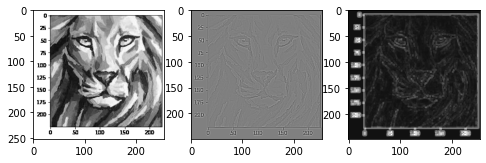

In [52]:
# 检测边缘
kernel_outline = torch.tensor([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]])
display_pooling(leo_arr,kernel_outline,(3,3))

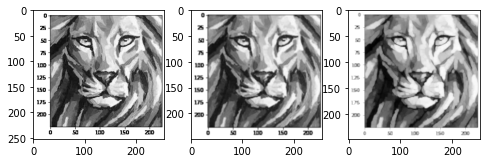

In [53]:
# 高斯模糊
kernel_outline = torch.tensor([[1, 2, 1],[2, 4, 2],[1, 2, 1]])/16.
display_pooling(leo_arr,kernel_outline,(3,3))

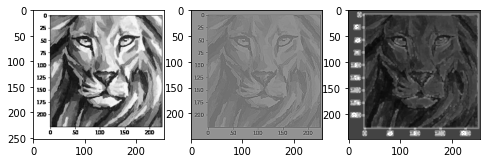

In [54]:
# 锐化卷积核
kernel_sharpen = torch.tensor([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
display_pooling(leo_arr,kernel_sharpen,(3,3))

## 填充和步幅

- 汇聚层与卷积层类似，都具有填充和步幅

\begin{example}\label{example:torchPooling}
用深度学习框架中内置的二维最大汇聚层，来演示汇聚层中填充和步幅的使用
\end{example}


### 默认情形

第一步：调整输入的形状

In [2]:
# 样本数是1，输入通道数是1，形状4*4
X = torch.arange(16, dtype=torch.float32 ).reshape((1,1,4,4)) 
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

第二步：调用nn.MaxPool2d

- 最大汇聚

```python
torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1)
```

- 平均汇聚

```python
torch.nn.AvgPool2d(kernel_size, stride=None, padding=0)
```

- `kernel_size`、`stride`、`padding`均可取`int`或者`tuple`
    - 取`int`：高和宽取相同的值
    - 取`tuple`：第一个是高，第二个是宽

In [33]:
maxPool2d = nn.MaxPool2d(3) # 3是窗口的高宽
maxPool2d(X)

tensor([[[[10.]]]])

>【注意】深度学习框架中默认的汇聚的步幅与汇聚窗口的大小相同

### 手动设定填充和步幅

#### 一般情形

In [34]:
maxPool2d = nn.MaxPool2d(3,padding=1,stride=2)

print(f'X\n{X}')
print(f'汇聚输出\n{maxPool2d(X)}')

X
tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])
汇聚输出
tensor([[[[ 5.,  7.],
          [13., 15.]]]])


#### 设定一个任意大小的矩形汇聚窗口，并分别设定填充和步幅的高度和宽度

In [35]:
maxPool2d = nn.MaxPool2d((2,3),padding=(1,1),stride=(2,3))
print(f'X\n{X}')
print(f'汇聚输出\n{maxPool2d(X)}')

X
tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])
汇聚输出
tensor([[[[ 1.,  3.],
          [ 9., 11.],
          [13., 15.]]]])


## 多个通道

- 在**每个输入通道**应用汇聚层以获得**相应的**输出通道（不像卷积核，会融合多个输入通道）
- 输出通道数<mark>$\bf{=}$</mark>输入通道数

\begin{example}\label{example:multiChannels}
在通道维度上连结张量$X$和$X + 1$，以构建具有2个通道的输入
\end{example}


In [36]:
print(f'张量 X\n{X}\n维度为 {X.shape}')

张量 X
tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])
维度为 torch.Size([1, 1, 4, 4])


In [37]:
X = torch.cat((X,X + 1), 1)
print(f'新张量X\n{X}\n维度为{X.shape}')

新张量X
tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
维度为torch.Size([1, 2, 4, 4])


In [38]:
maxPool2d = nn.MaxPool2d(3,padding=1,stride=2)
# 汇聚后输出通道数仍为2
maxPool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 空洞卷积

- **空洞卷积**（dialation convolution）：又被称作扩张卷积（astrous convolution），在不增加计算参数的情况下扩大卷积层的感受野

- 通过扩张率（dialation rate）调整卷积核中相邻元素的距离，使得同样尺寸的卷积核获得更大的感受野

- 扩张率为1时的卷积核

<center><img src="../img/6_convolutional_neural_networks/Dilated_Convolution_r1.webp" width=60%></center>

- 扩张率为2时的卷积核

<center><img src="../img/6_convolutional_neural_networks/Dilated_Convolution_r2.webp" width=60%></center>

- 扩张率为4时的卷积核

<center><img src="../img/6_convolutional_neural_networks/Dilated_Convolution_r4.webp" width=60%></center>

- 若卷积核的大小为$K$，扩张率为$D$，则空洞卷积核大小为$K+(K-1)\times(D-1)$

- 卷积核
```python
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True, padding_mode='zeros')
```

- 最大汇聚
```python
torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1)
```

- `dialation`
    - 取`int`：高和宽取相同的值
    - 取`tuple`：第一个是高，第二个是宽

In [12]:
Y = torch.arange(64, dtype=torch.float32).reshape((1,1,8,8)) 
Y

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11., 12., 13., 14., 15.],
          [16., 17., 18., 19., 20., 21., 22., 23.],
          [24., 25., 26., 27., 28., 29., 30., 31.],
          [32., 33., 34., 35., 36., 37., 38., 39.],
          [40., 41., 42., 43., 44., 45., 46., 47.],
          [48., 49., 50., 51., 52., 53., 54., 55.],
          [56., 57., 58., 59., 60., 61., 62., 63.]]]])

In [13]:
maxPool2Dilation = nn.MaxPool2d(kernel_size=3,dilation=2)
maxPool2Dilation(Y)

tensor([[[[36., 39.],
          [60., 63.]]]])